<a href="https://colab.research.google.com/github/Konstantin-Iakovlev/2021-Optimization_Project/blob/main/SQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stochastic Quasi Newton methods for Neural Networks 

In [111]:
import numpy as np
from stochqn import oLBFGS
from stochqn import SQN
from sklearn.linear_model._logistic import _logistic_loss_and_grad, _logistic_grad_hess
from sklearn.datasets import load_digits
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
def batch(iterable_X, iterable_y, n=1):
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]

def obj_fun(w, X, y, sample_weight=None, reg_param=1.0):
    return _logistic_loss_and_grad(w, X, y, reg_param, sample_weight)[0]

def grad_fun(w, X, y, sample_weight=None, reg_param=1.0):
    # print(w.shape, X.shape, y.shape)
    # (65,) (72, 64) (72,)
    return _logistic_loss_and_grad(w, X, y, reg_param, sample_weight)[1]

def hess_fun(w, vec, X, y, sample_weight=None, reg_param=1.0):
    return _logistic_grad_hess(w, X, y, reg_param, sample_weight)[1](vec)

def pred_fun(w, X):
	return 1 / (1 + np.exp(-X.dot(w[:X.shape[1]]) - w[-1]))

digits = load_digits()
X = digits["data"]
y = (digits["target"] == 3).astype('int64') ### picked one class at random
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(f'X shape = {X.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

np.random.seed(1)
w0 = np.random.normal(size = X.shape[1] + 1)


optimizer = oLBFGS(x0=w0, grad_fun=grad_fun, obj_fun=obj_fun, nepochs=1,
                   pred_fun=pred_fun, step_size=5e-6)
sqn_optimizer = SQN(x0=w0, grad_fun=grad_fun, obj_fun=obj_fun, nepochs=1,
                    pred_fun=pred_fun, hess_vec_fun=hess_fun, step_size=5e-6)
Q_arr = []
Q_sgd = []
Q_sqn = []
for i in range(200):
    optimizer.partial_fit(X_train, y_train,sample_weight=None,
                          additional_kwargs={"reg_param" : 1.0})
    Q_arr.append(log_loss(y_test, optimizer.predict(X_test)))
for i in range(200):
    sqn_optimizer.partial_fit(X_train, y_train,sample_weight=None,
                          additional_kwargs={"reg_param" : 1.0})
    Q_sqn.append(log_loss(y_test, sqn_optimizer.predict(X_test)))

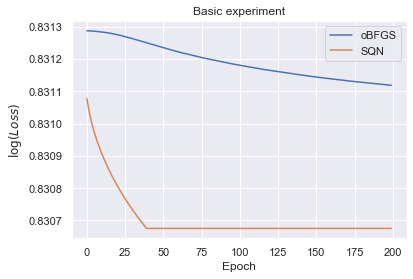

In [110]:

plt.plot(np.log(np.array(Q_arr)), label='oBFGS')
plt.plot(np.log(np.array(Q_sqn)), label='SQN')
plt.xlabel('Epoch')
plt.ylabel('$\log(Loss)$')
plt.legend()
plt.title('Basic experiment')
plt.show()

### Main experiment



In [1]:
! git clone https://github.com/cthl/sqgn
% cd sqgn/mnist_tf
! python mnist_tf.py -opt_name sqn

Cloning into 'sqgn'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 62 (delta 27), reused 42 (delta 17), pack-reused 0
Unpacking objects: 100% (62/62), done.


UsageError: Line magic function `%` not found.


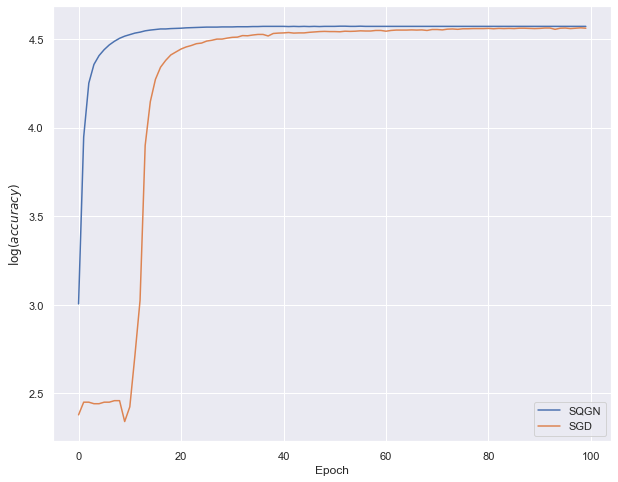

In [29]:
import re
from matplotlib import pylab as plt
import seaborn as sns
import numpy as np

sns.set()

def get_acc(filename):
    acc_arr = []
    with open(filename, 'r') as fin:
        for line in fin:
            found = re.findall('acc. = \d\d.\d', line)
            if found:
                acc_arr.append(float(found[0][-4:]))
    return np.array(acc_arr)

plt.figure(figsize=(10, 8))
sqn_acc = get_acc('sqn_nn.log')
plt.plot(np.log(sqn_acc), label='SQGN')
sgd_acc = get_acc('sgd_nn.log')
plt.plot(np.log(sgd_acc), label='SGD')

plt.xlabel('Epoch')
plt.ylabel('$\log(accuracy)$')
plt.legend()
plt.show()
